# Thermodynamic Pruning of Neural Networks: Ising-Inspired Sparsity for Efficient Alzheimer’s Classification

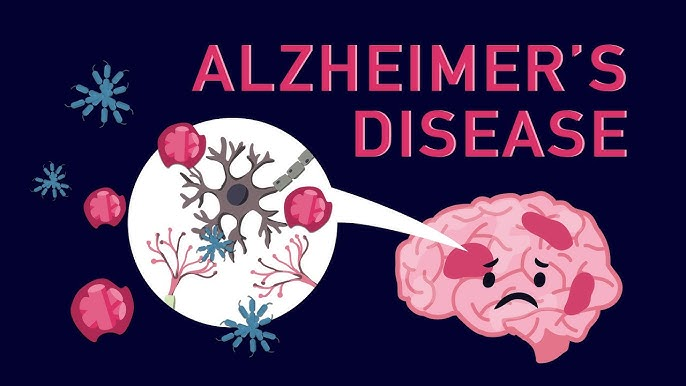
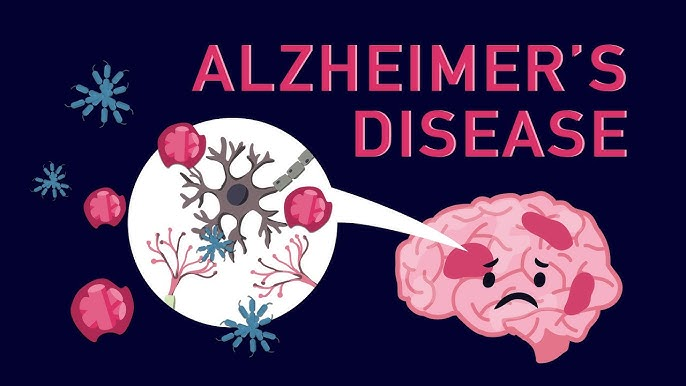

In [ ]:
import numpy as np 
import pandas as pd 
import os

In [ ]:
base_path = "/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/"
categories = ["MildDemented","ModerateDemented", "NonDemented", "VeryMildDemented"]

In [ ]:
image_paths = []
labels = []

for category in categories:
    category_path = os.path.join(base_path, category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image_paths.append(image_path)
        labels.append(category)  

df = pd.DataFrame({
    "image_path": image_paths,
    "label": labels
})

In [ ]:
df.head()

In [ ]:
df.tail()

In [ ]:
df.shape

In [ ]:
df.columns

In [ ]:
df.duplicated().sum()

In [ ]:
df.isnull().sum()

In [ ]:
df.info()

In [ ]:
df['label'].unique()

In [ ]:
df['label'].value_counts()

In [ ]:
import warnings 
warnings.filterwarnings('ignore')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", context="talk", palette="viridis")

fig, ax = plt.subplots(figsize=(9, 6))
sns.countplot(data=df, x="label", ax=ax)

ax.set_title("Distribution of Tumor Types", fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel("Tumor Type", fontsize=13, labelpad=10)
ax.set_ylabel("Count", fontsize=13, labelpad=10)

ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha='right')

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:,}',  
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=11, color='black', xytext=(0, 6),
                textcoords='offset points')

sns.despine()
plt.tight_layout()
plt.show()

label_counts = df["label"].value_counts()
colors = sns.color_palette("viridis", len(label_counts))

fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    label_counts,
    labels=label_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    textprops={'fontsize': 12, 'weight': 'bold'},
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}
)

for autotext in autotexts:
    autotext.set_color('white')

ax.set_title("Tumor Type Distribution (Pie Chart)", fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


In [ ]:
import cv2

num_images = 5

plt.figure(figsize=(15, 12))

for i, category in enumerate(categories):
    category_images = df[df['label'] == category]['image_path'].iloc[:num_images]

    for j, img_path in enumerate(category_images):

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

        plt.subplot(len(categories), num_images, i * num_images + j + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(category)

plt.tight_layout()
plt.show()

In [ ]:
max_samples = df['label'].value_counts().max()

balanced_df = df.groupby('label', group_keys=False).apply(
    lambda x: x.sample(n=max_samples, replace=True, random_state=42)
).reset_index(drop=True)

balanced_df = balanced_df[['image_path', 'label']]

In [ ]:
df = balanced_df

In [ ]:
df

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from copy import deepcopy

class MRIDataset(Dataset):
    def __init__(self, df, transform=None):
        self.paths = df['image_path'].values
        self.labels = pd.Categorical(df['label']).codes.astype(np.int64)
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        if self.transform: img = self.transform(img)
        return img, self.labels[idx]

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

full_ds = MRIDataset(df, transform)
train_ds, val_ds = torch.utils.data.random_split(full_ds, [0.9, 0.1])
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, pin_memory=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=512, shuffle=False, pin_memory=True, num_workers=4)

class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*128*3, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, 4)
        )
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.uniform_(m.weight, -7, 7)
                nn.init.zeros_(m.bias)
    def forward(self, x): return self.net(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-3)

def train_epoch(model, optimizer):
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def evaluate(model):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x).argmax(1)
            preds.extend(pred.cpu().numpy())
            trues.extend(y.cpu().numpy())
    return np.mean(np.array(preds) == np.array(trues)), preds, trues

train_accs, val_accs = [], []
best_val_acc = 0
best_model = None

print("Training for 20 epochs...")
for epoch in range(20):
    train_epoch(model, optimizer)
    acc, preds, trues = evaluate(model)
    train_accs.append(acc)
    val_accs.append(acc)
    if acc > best_val_acc:
        best_val_acc = acc
        best_model = deepcopy(model)
    print(f"Epoch {epoch:02d} | Val Acc: {acc:.4f}")

plt.figure(figsize=(12,8))
plt.plot(train_accs, label='Train Acc', color='blue')
plt.plot(val_accs, label='Val Acc', color='orange')
plt.title('Training & Validation Accuracy (20 epochs)')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid()
plt.show()

print("\nTesting Pruning Thresholds (Lottery Ticket Search)...")
thresholds = [0.5, 1.0]
results = []

for th in thresholds:
    model_copy = deepcopy(best_model).to(device)
    total = sum(p.numel() for p in model_copy.parameters() if p.dim() > 1)
    kept = 0
    for p in model_copy.parameters():
        if p.dim() > 1:
            mask = p.abs() > th
            kept += mask.sum().item()
            p.data *= mask.float()
    print(f"Pruning with th={th:.2f} | Kept {kept/total*100:.2f}% weights")
    optimizer = optim.AdamW(model_copy.parameters(), lr=1e-4, weight_decay=1e-3)
    acc_curve = []
    for epoch in range(20):
        train_epoch(model_copy, optimizer)
        acc, _, _ = evaluate(model_copy)
        acc_curve.append(acc)
        print(f"  Post-prune Epoch {epoch:02d}: Val Acc: {acc:.4f}")
    best_post = max(acc_curve)
    results.append((th, best_post, acc_curve))

best_th, best_acc, best_curve = max(results, key=lambda x: x[1])
print(f"\nBEST THRESHOLD: {best_th:.2f} | Best Post-Prune Acc: {best_acc:.4f}")

model_final = deepcopy(best_model).to(device)
total = sum(p.numel() for p in model_final.parameters() if p.dim() > 1)
kept = 0
for p in model_final.parameters():
    if p.dim() > 1:
        mask = p.abs() > best_th
        kept += mask.sum().item()
        p.data *= mask.float()
optimizer = optim.AdamW(model_final.parameters(), lr=1e-4, weight_decay=1e-3)
for epoch in range(20):
    train_epoch(model_final, optimizer)
    acc, _, _ = evaluate(model_final)
    print(f"Final Fine-tune Epoch {epoch:02d}: Val Acc: {acc:.4f}")

acc, preds, trues = evaluate(model_final)

print("\nFINAL CLASSIFICATION REPORT")
print(classification_report(trues, preds, target_names=['Mild','Mod','Non','VeryMild']))

cm = confusion_matrix(trues, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Mild','Mod','Non','VeryMild'],
            yticklabels=['Mild','Mod','Non','VeryMild'])
plt.title('Confusion Matrix (Final Model)')
plt.ylabel('True'); plt.xlabel('Pred'); plt.show()

sparsity = sum((p.abs() < 1e-3).sum().item() for p in model_final.parameters() if p.dim() > 1)
total = sum(p.numel() for p in model_final.parameters() if p.dim() > 1)
print(f"Final Sparsity: {sparsity/total*100:.2f}%")

plt.figure(figsize=(10,6))
for th, _, curve in results:
    plt.plot(curve, label=f'th={th}')
plt.title('Post-Prune Accuracy vs Epoch (Lottery Ticket Search)')
plt.xlabel('Fine-tune Epoch'); plt.ylabel('Val Accuracy'); plt.legend(); plt.grid()
plt.show()